# Advanced Deep Learning and Reinforcement Learning. Домашнее задание 2

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован
Environment для крестиков-ноликов, в котором можно при инициализации указывать
разные размеры доски и условия победы, а также функции для рисования, в том числе с
указанием оценки различных действий. С этим окружением все задания и связаны.

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getHash()

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s, a]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if (s, (0, 0)) in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s, a])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, actions)

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        actions = [tuple(a) for a in actions]
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

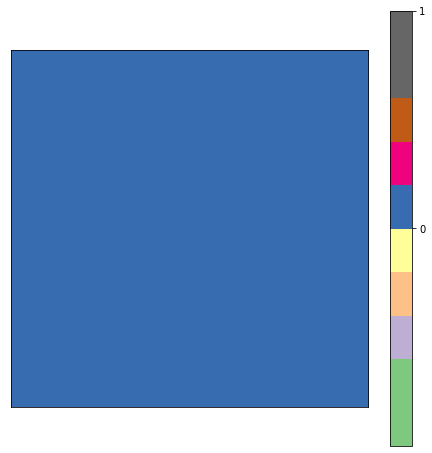

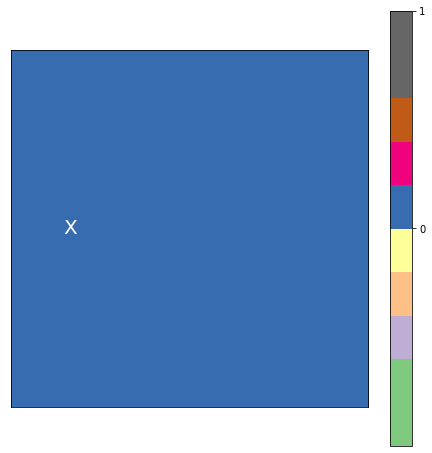

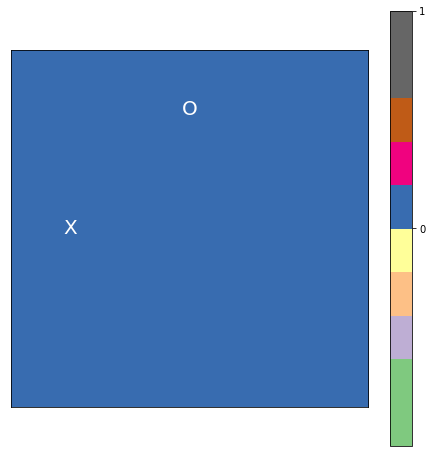

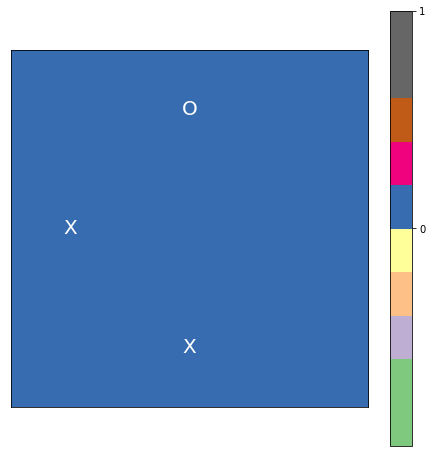

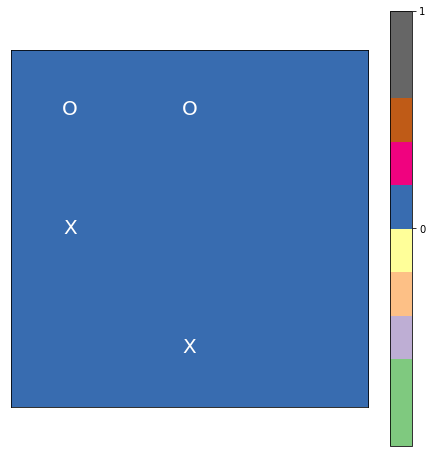

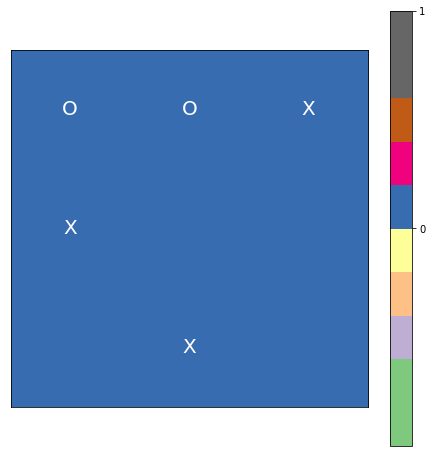

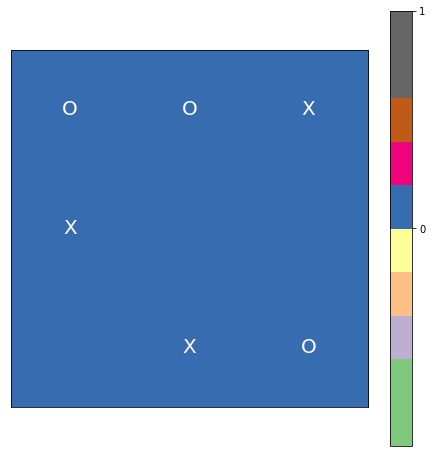

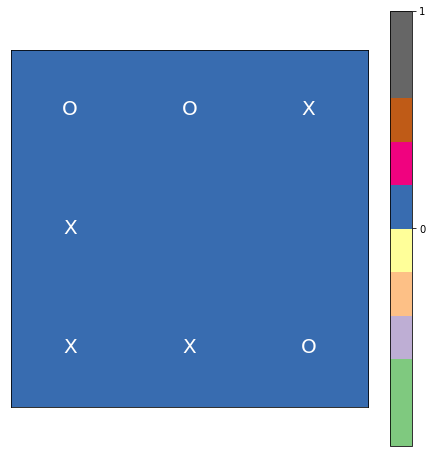

Нолики выиграли!


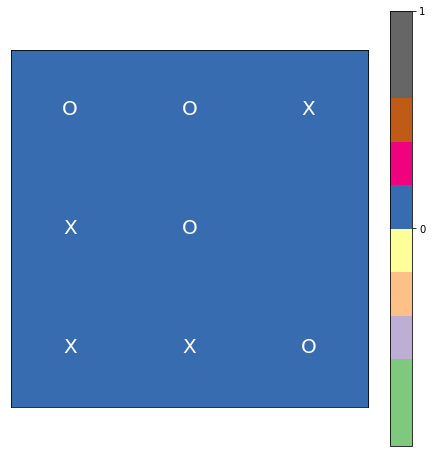

In [6]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

### Задание 1
Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и
ноликов для доски 3х3.

In [7]:
from collections import defaultdict


class QLearning:
    def __init__(self, env, alpha, epsilon, seed=None):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: 0)
        
        np.random.seed(seed)
        env.seed(seed)
        
        self.action_space = list()
        for i in range(self.env.n_rows):
            for j in range(self.env.n_cols):
                self.action_space.append((i, j))
                
    
    def getActionGreedy(self, state, actions):
        best_Q, best_i = self.Q[(state, actions[0])], 0
        for i, action in enumerate(actions):
            current_Q = self.Q[(state, action)]
            if current_Q > best_Q:
                best_Q, best_i = current_Q, i
        return best_i
    
    def __get_action_greedy(self, state):
        i = self.getActionGreedy(state, self.action_space)
        action = self.action_space[i]
        return action, self.Q[(state, action)]
    
    def __get_action_epsilon_greedy(self, state):
        if np.random.random() < self.epsilon:
            return self.action_space[np.random.randint(0, len(self.action_space))]
        return self.__get_action_greedy(state)[0]
    
    def fit(self, n_trials):
        for _ in range(n_trials):
            prev_state = None
            prev_action = None
            state = self.env.reset()
            mark = 0
            done = False
            while not done:
                action = self.__get_action_epsilon_greedy(state)
                new_state, reward, done, _ = self.env.step(action)
                new_state = new_state[0]
                if prev_state is not None:
                    if (reward != -10):
                        r = 1 if mark == 1 else -1
                        self.Q[(prev_state, prev_action)] += (self.alpha * (r * reward
                            + self.__get_action_greedy(new_state)[1]
                            - self.Q[(prev_state, prev_action)]))
                        
                prev_action = action
                prev_state = state
                state = new_state
                mark ^= 1
                
            r = -1 if mark == 0 and reward != -10 else 1
            self.Q[(prev_state, prev_action)] += (self.alpha * (r * reward
                - self.Q[(prev_state, prev_action)]))
    
    def predict(self, state, _):
        return self.__get_action_greedy(state)[0]

In [8]:
from tqdm.notebook import tqdm


class Pipeline:
    def __init__(self, strategy):
        self.strategy = strategy

    def train(self, epoch, n_trials, n_evaluate):
        res = []
        ns_trials = []
        for _ in tqdm(range(epoch)):
            self.strategy.fit(n_trials)
            res.append(self.evaluate(n_evaluate))
            ns_trials.append(n_trials + (ns_trials[-1] if len(ns_trials) else 0))

        plt.plot(ns_trials, list(zip(*res))[0], label='X')
        plt.plot(ns_trials, list(zip(*res))[1], label='O')
        plt.xlabel('n_trials')
        plt.ylabel('score')
        plt.title('Q-learning score')
        plt.legend()
    
    def evaluate(self, n_trials):
        eval_results = []
        figures = ['crosses', 'noughts']
        for figure in range(len(figures)):
            res = 0
            for _ in range(n_trials):
                state = self.strategy.env.reset()
                next_move = 0
                done = False
                while not done:
                    if next_move == figure:
                        action = self.strategy.predict(state, figures[figure])
                    else:
                        action_space = self.strategy.env.getEmptySpaces()
                        action = tuple(action_space[np.random.randint(0, len(action_space))])
                    
                    state, reward, done, _ = env.step(action)
                    state = state[0]
                    next_move ^= 1
                    
                if figures == 1 and reward != -10:
                    reward *= -1
                res += reward
                
            res /= n_trials
            eval_results.append(res)
        return eval_results

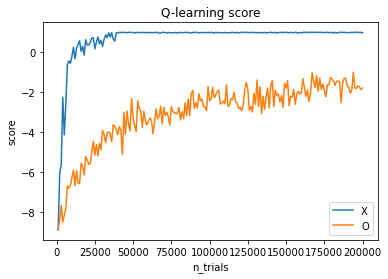

In [9]:
env = TicTacToe(3, 3, 3)
q_learning = QLearning(env, alpha=1e-2, epsilon=0.2, seed=42)
pipeline = Pipeline(q_learning)
pipeline.train(200, 1000, 100)

Q-Learning vs random policy : 0.996
Random policy vs Q-Learning: -1.785


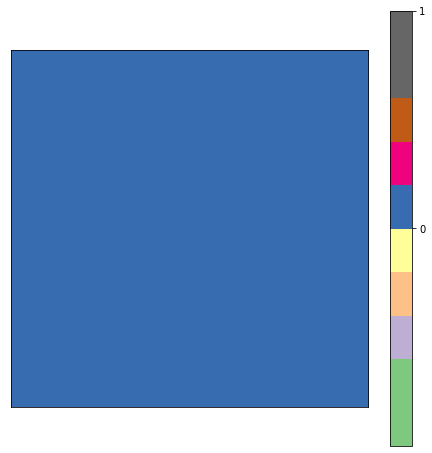

0 (0, 0) 0.2691027682196666
1 (0, 1) 0.1430278847094845
2 (0, 2) 0.15931925309595474
3 (1, 0) 0.05980971413901185
4 (1, 1) 0.016233387088696156
5 (1, 2) 0.014063831818923378
6 (2, 0) 0.07285061191396182
7 (2, 1) 0.014513342375372596
8 (2, 2) 0.10473860507516794


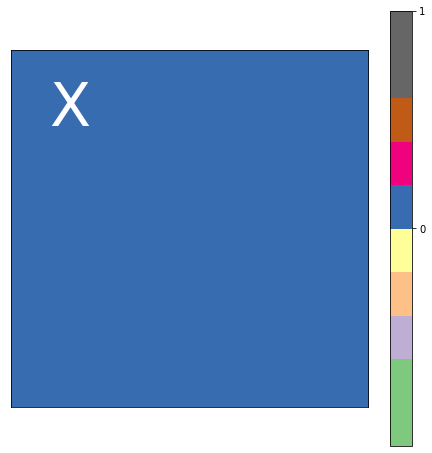

0 (0, 1) -0.694491408245305
1 (0, 2) -0.6414919624698748
2 (1, 0) -0.6731891577771193
3 (1, 1) 0.14753167579999169
4 (1, 2) -0.6700306532525979
5 (2, 0) -0.6477998596859502
6 (2, 1) -0.6206491982420279
7 (2, 2) -0.6537816214221689


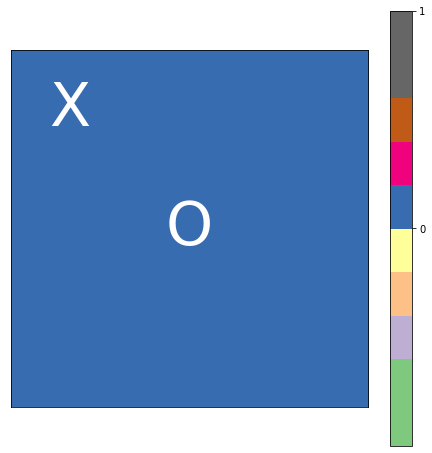

0 (0, 1) 0.18870642691713732
1 (0, 2) 0.09675181433380318
2 (1, 0) 0.08678764701192157
3 (1, 2) 0.01782111949486578
4 (2, 0) 0.08037851365914753
5 (2, 1) 0.019413468131578706
6 (2, 2) 0.05613686733712833


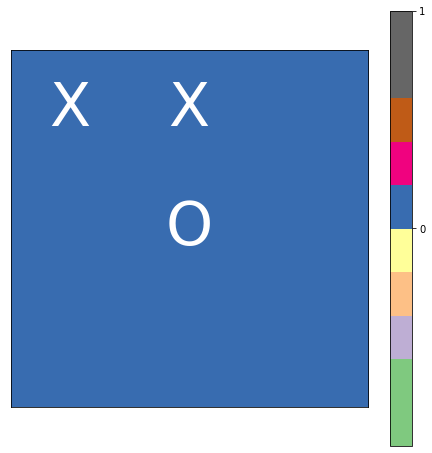

0 (0, 2) 0.1531743202534569
1 (1, 0) -0.8923176699410552
2 (1, 2) -0.8869537373764679
3 (2, 0) -0.8572139906645821
4 (2, 1) -0.908536739094027
5 (2, 2) -0.9237234958199038


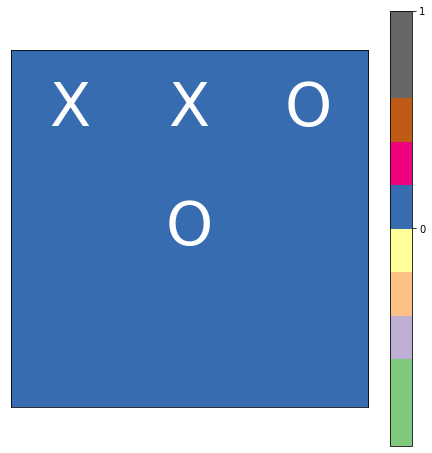

0 (1, 0) -0.8629235618579771
1 (1, 2) -0.9055968033414347
2 (2, 0) 0.07645544707470642
3 (2, 1) -0.9231780600374307
4 (2, 2) -0.9316670622453839


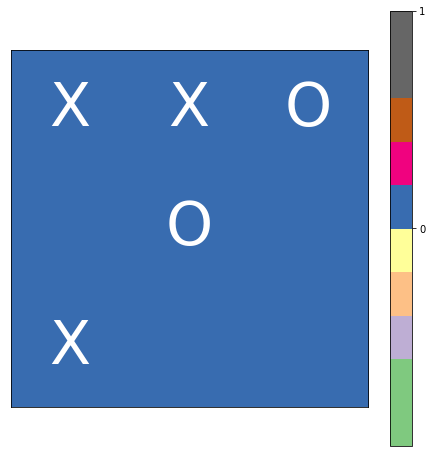

0 (1, 0) 0.05593255362471614
1 (1, 2) -0.9430530806697754
2 (2, 1) -0.9245914125909654
3 (2, 2) -0.9009120950570259


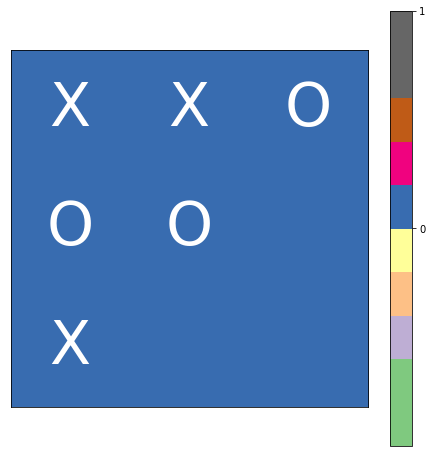

0 (1, 2) 0.0
1 (2, 1) -0.9121286276112053
2 (2, 2) -0.9252133189156182


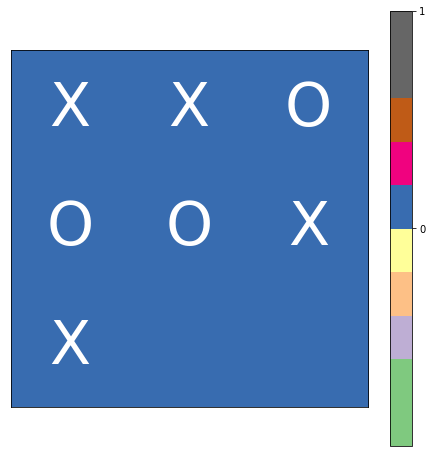

0 (2, 1) 0.0
1 (2, 2) 0.0


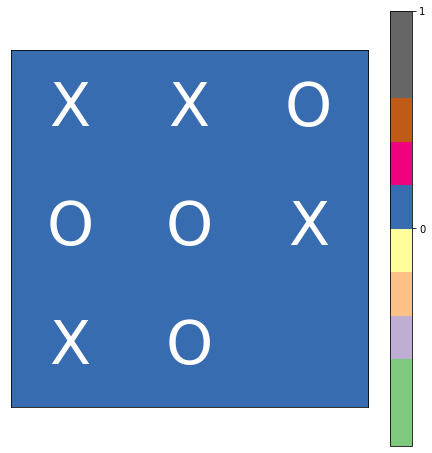

0 (2, 2) 0.0


In [10]:
cross_res, nought_res = pipeline.evaluate(1000)
print(f'Q-Learning vs random policy : {cross_res}')
print(f'Random policy vs Q-Learning: {nought_res}')
plot_test_game(env, q_learning, q_learning, random_naughts=False)

### Задание 2
Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.
Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать
большого терпения или более сложных вычислительных реализаций (например,
параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так
что если не будет получаться доучить до победных стратегий, не страшно -- но покажите,
что со временем что-то всё-таки улучшается.


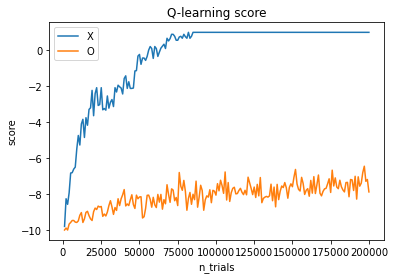

In [11]:
env = TicTacToe(4, 4, 3)
q_learning = QLearning(env, alpha=1e-2, epsilon=0.2, seed=42)
pipeline = Pipeline(q_learning)
pipeline.train(200, 1000, 100)

Q-Learning vs random policy : 1.0
Random policy vs Q-Learning: -7.353


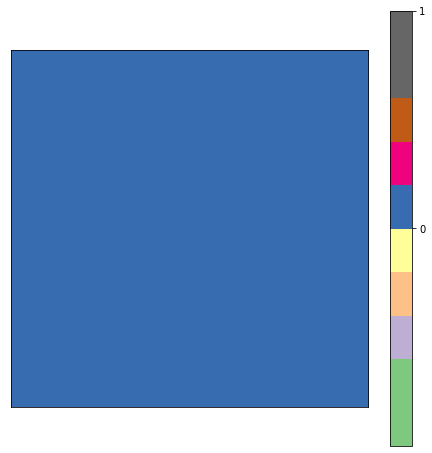

0 (0, 0) 0.6473773731710295
1 (0, 1) 0.011991572829669605
2 (0, 2) 0.002279636525935674
3 (0, 3) 0.0023236368072529533
4 (1, 0) 0.00498641301393929
5 (1, 1) 0.001228969344027797
6 (1, 2) 0.00866142857581547
7 (1, 3) 0.0008434120428575381
8 (2, 0) 0.001040481792416562
9 (2, 1) 0.0003656488072674788
10 (2, 2) 0.005855504929190902
11 (2, 3) 0.00391413450808412
12 (3, 0) 0.00026528382279977753
13 (3, 1) 1.1602172423595092e-06
14 (3, 2) 2.3875993839392565e-05
15 (3, 3) 0.0019801959713650107


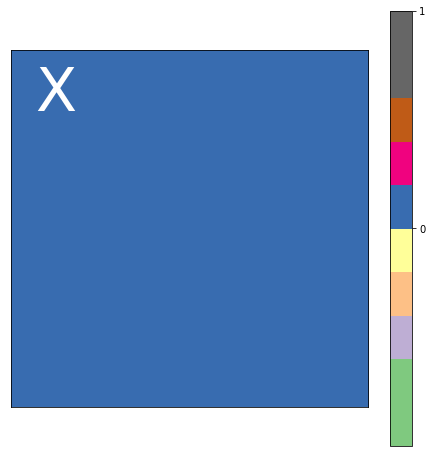

0 (0, 1) -0.35923207415340824
1 (0, 2) -0.3641858931106487
2 (0, 3) -0.34325837803842363
3 (1, 0) -0.34857365947723323
4 (1, 1) -0.3430789490083209
5 (1, 2) -0.345139034634125
6 (1, 3) -0.36431892368257757
7 (2, 0) -0.3548252657345044
8 (2, 1) -0.3545170684708646
9 (2, 2) -0.35250791212165966
10 (2, 3) -0.3374752311768657
11 (3, 0) -0.34912549161642387
12 (3, 1) -0.35135668582265983
13 (3, 2) -0.3431096462548833
14 (3, 3) -0.35911631842883046


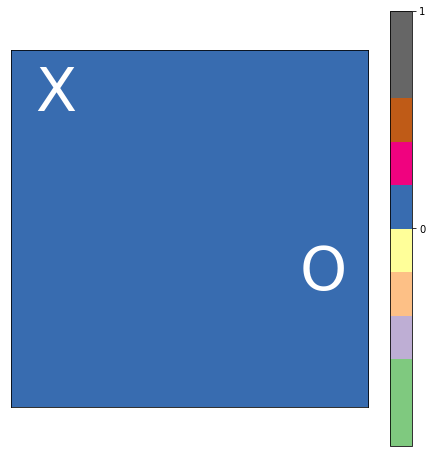

0 (0, 1) 0.6136457750494346
1 (0, 2) 0.00284574083065959
2 (0, 3) 5.843359656135765e-07
3 (1, 0) 0.016035408374468395
4 (1, 1) 0.0005917754425725591
5 (1, 2) 9.543857752835336e-07
6 (1, 3) 0.0
7 (2, 0) 6.658830898365753e-05
8 (2, 1) 1.2219251823957285e-06
9 (2, 2) 0.0005313233590728165
10 (3, 0) 2.7567720106704124e-08
11 (3, 1) 0.0
12 (3, 2) 0.0
13 (3, 3) 0.0


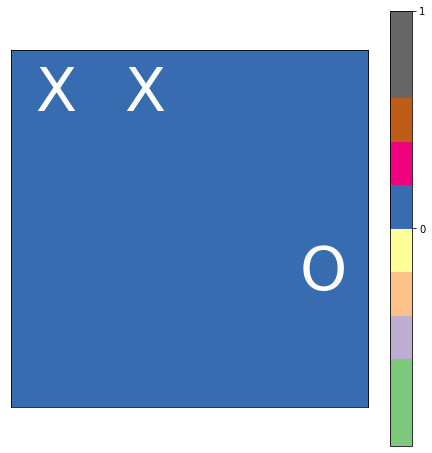

0 (0, 2) -0.3935486896677517
1 (0, 3) -0.43816202071920496
2 (1, 0) -0.4296430668772524
3 (1, 1) -0.42183336172899905
4 (1, 2) -0.4297433937712299
5 (1, 3) -0.42577056336794583
6 (2, 0) -0.44191262697824435
7 (2, 1) -0.45418310798515893
8 (2, 2) -0.4252082217423372
9 (3, 0) -0.44340641060263286
10 (3, 1) -0.43328185914511247
11 (3, 2) -0.42822113396319805
12 (3, 3) -0.4789757938180411


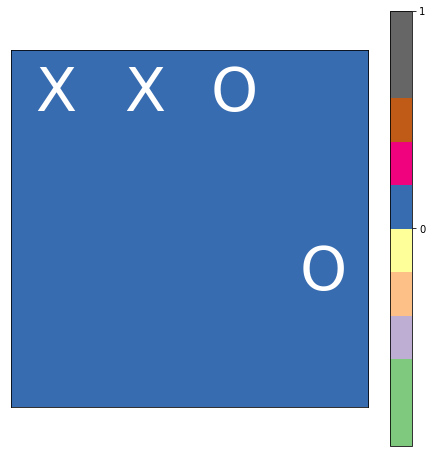

0 (0, 3) 6.459004474957465e-05
1 (1, 0) 0.6300371245432911
2 (1, 1) 0.006755810632825977
3 (1, 2) 0.004955937415232017
4 (1, 3) 0.0
5 (2, 0) 0.0
6 (2, 1) 0.0
7 (2, 2) 0.0004710744016920366
8 (3, 0) 0.0
9 (3, 1) 0.0
10 (3, 2) 0.0
11 (3, 3) 0.0


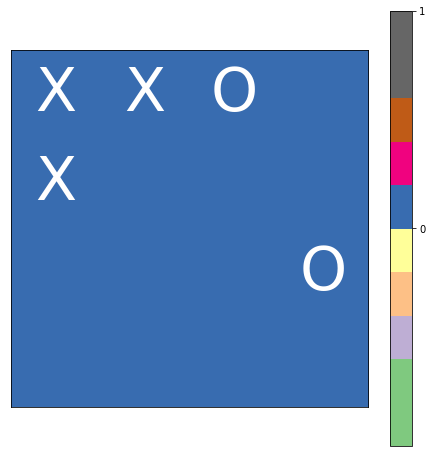

0 (0, 3) -0.5001507778470637
1 (1, 1) -0.5017325045583939
2 (1, 2) -0.48884731975969314
3 (1, 3) -0.5148378810371282
4 (2, 0) -0.4633526486997921
5 (2, 1) -0.494856137078155
6 (2, 2) -0.4955798625985214
7 (3, 0) -0.4967015801450357
8 (3, 1) -0.4955550559505045
9 (3, 2) -0.49221118973074895
10 (3, 3) -0.5044932971255106


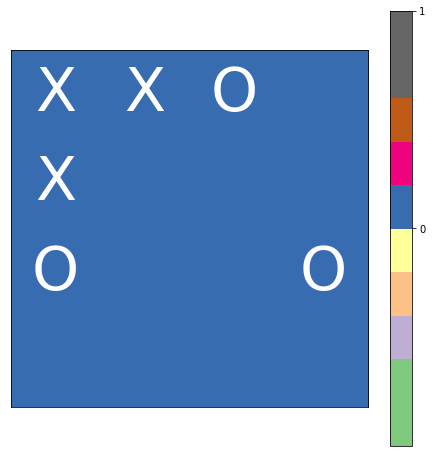

0 (0, 3) -0.18908719619925643
1 (1, 1) 0.6691514249180355
2 (1, 2) 0.0
3 (1, 3) 0.0
4 (2, 1) -0.0490099501
5 (2, 2) -0.058519850599
6 (3, 0) 0.0
7 (3, 1) 0.0
8 (3, 2) 0.0
9 (3, 3) 0.0


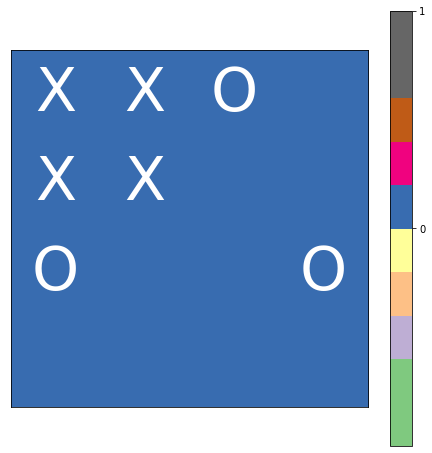

0 (0, 3) -0.5969307849258821
1 (1, 2) -0.5982468600182346
2 (1, 3) -0.5973935267529814
3 (2, 1) -0.5988477864721068
4 (2, 2) -0.5966916468220154
5 (3, 0) -0.5959253519546667
6 (3, 1) -0.5954801610037144
7 (3, 2) -0.5962001040616483
8 (3, 3) -0.5990524835319018


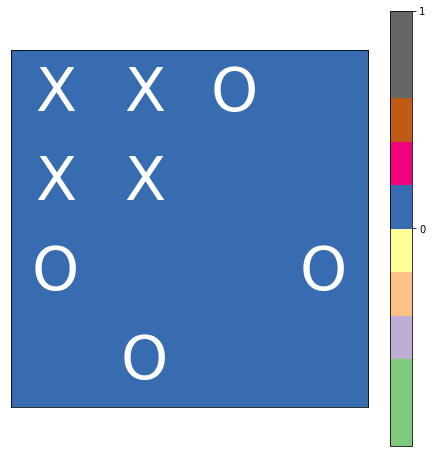

0 (0, 3) 9.900000000000001e-05
1 (1, 2) 0.029701
2 (1, 3) 0.0
3 (2, 1) 0.8345374043352651
4 (2, 2) 0.029701
5 (3, 0) 0
6 (3, 2) 0
7 (3, 3) 0.0
Крестики выиграли!


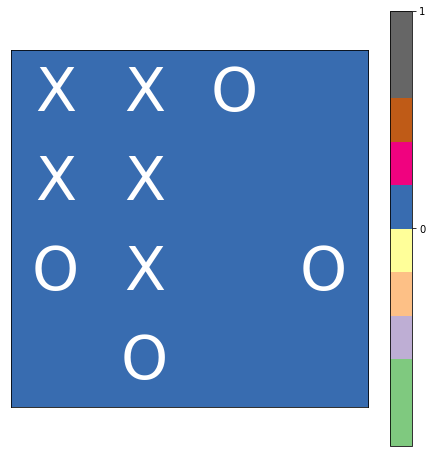

In [12]:
cross_res, nought_res = pipeline.evaluate(1000)
print(f'Q-Learning vs random policy : {cross_res}')
print(f'Random policy vs Q-Learning: {nought_res}')
plot_test_game(env, q_learning, q_learning, random_naughts=False)

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду
ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в
том числе обобщаться на доски размера побольше).


### Задание 3
Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.
Замечание: скорее всего, experience replay потребуется сразу же.

In [13]:
from torch.autograd import Variable

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import random

In [14]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [15]:
class FigureModel:
    def __init__(self, model_cls, memory_size, lr):
        self.model = model_cls()
        self.memory = ReplayMemory(memory_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr)

In [16]:
class TicTacToeDQN:
    def __init__(self, env,
                 model_cls, memory_size=10000, lr=0.001, # pass through params for Model
                 gamma=0.8, batch_size=64,
                 eps_init=0.9, eps_final=0.05, eps_decay=200):
        self.env = env
        self.crosses = FigureModel(model_cls, memory_size, lr)
        self.noughts = FigureModel(model_cls, memory_size, lr)
        
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.eps_init, self.eps_final, self.eps_decay = eps_init, eps_final, eps_decay
        self.num_step = 0
        
        self.action_space = list()
        for i in range(self.env.n_rows):
            for j in range(self.env.n_cols):
                self.action_space.append((i, j))
        
    def select_greedy_action(self, state, model):
        return model(state).data.max(1)[1].view(1, 1)
    
    def select_action(self, state, model):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, model)
        else:
            action_space = self.env.getEmptySpaces()
            action = action_space[np.random.randint(0, len(action_space))]
            return torch.tensor([[self.env.n_cols * action[0] + action[1]]], dtype=torch.int64)
        
    def unroll_state_to_tensor(self, board_hash):
        board_hash = np.array([int(digit) for digit in board_hash])
        res = np.zeros((3, self.env.n_rows * self.env.n_cols))
        for i in range(3):
            res[i, :] = board_hash == i
        return torch.unsqueeze(torch.Tensor(res.reshape(3, self.env.n_rows, self.env.n_cols)).to(torch.float32), 0)
        
    def run_episode_for_figure_model(self, figure_model, initial_state, greedy=False, noughts=False):
        def store(state, action, next_state, reward):
            if noughts and int(abs(reward)) == 1:
                reward *= -1
            next_state = self.unroll_state_to_tensor(next_state)
            transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
            figure_model.memory.store(transition)
            return next_state
        
        state = self.unroll_state_to_tensor(initial_state)
        done = False
        while not done:
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state, figure_model.model)
                else:
                    action = self.select_action(state, figure_model.model)
            
            (next_state, empty_spaces, _), reward, done, _ = self.env.step(self.action_space[action.numpy()[0][0]])
            if done:
                store(state, action, next_state, reward)
                break
            
            enemy_action = tuple(empty_spaces[np.random.randint(0, len(empty_spaces))])
            (next_state, _, _), reward, done, _ = self.env.step(enemy_action)
            next_state = store(state, action, next_state, reward)
            
            state = next_state
            
    def run_episode(self, do_learning=True, greedy=False):
        state = self.env.reset()
        self.run_episode_for_figure_model(self.crosses, state, greedy=greedy)
        
        # make crosses move
        state = self.env.reset()
        action = tuple(self.action_space[np.random.randint(0, len(self.action_space))])
        state = self.env.step(action)[0][0]
        self.run_episode_for_figure_model(self.noughts, state, greedy=greedy, noughts=True)
        
        if do_learning:
            self.learn()
                
    def learn_figure_model(self, figure_model):
        if len(figure_model.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = figure_model.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = figure_model.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = figure_model.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        figure_model.optimizer.zero_grad()
        loss.backward()
        figure_model.optimizer.step()
        
    def learn(self):
        self.learn_figure_model(self.crosses)
        self.learn_figure_model(self.noughts)
        
    def fit(self, n_trials, n_learn_percentage=0.1):
        for _ in range(n_trials):
            self.run_episode(do_learning=False)
        for _ in range(int(n_trials * n_learn_percentage)):
            self.learn()
    
    def predict(self, state, figure):
        state = self.unroll_state_to_tensor(state)
        figure_model = self.crosses if figure == 'crosses' else self.noughts
        model = figure_model.model
        with torch.no_grad():
            action = self.action_space[self.select_greedy_action(state, model).numpy()[0][0]]
        return action

In [25]:
class Network_3_3(nn.Module):
    def __init__(self, num_channels=256):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, num_channels, 3)
        self.l1 = nn.Linear(num_channels, num_channels)
        self.l2 = nn.Linear(num_channels, 9)
    
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.relu(self.l1(torch.flatten(x, start_dim=1)))
        x = self.l2(x)
        return x

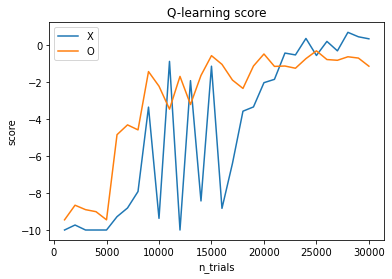

In [26]:
env = TicTacToe(3, 3, 3)
dqn = TicTacToeDQN(env, Network_3_3, batch_size=256, lr=3e-5, memory_size=10000)
pipeline = Pipeline(dqn)
pipeline.train(30, 1000, 100)

### Задание 4
Реализуйте Double DQN и/или Dueling DQN

In [27]:
class DuelingNetwork_3_3(nn.Module):
    def __init__(self, num_channels=256):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, num_channels, 3)
        self.l1 = nn.Linear(num_channels, num_channels)
        self.a_l = nn.Linear(num_channels, 9)
        self.v_l = nn.Linear(num_channels, 1)
    
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.relu(self.l1(torch.flatten(x, start_dim=1)))
        action_advantages = self.a_l(x)
        state_value = self.v_l(x)
        x = action_advantages + state_value - torch.mean(action_advantages, 1, True)
        return x

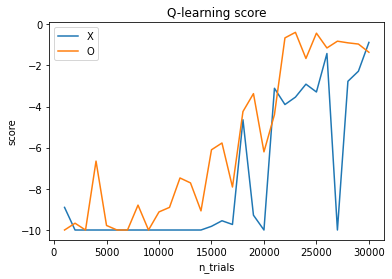

In [28]:
env = TicTacToe(3, 3, 3)
dqn = TicTacToeDQN(env, DuelingNetwork_3_3, batch_size=256, lr=3e-5, memory_size=10000)
pipeline = Pipeline(dqn)
pipeline.train(30, 1000, 100)

## Часть третья: расширим и углубим поиск

Крестики-нолики $-$ это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением
здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы
всё-таки для этого учебного задания будем реализовывать более практически
релевантный метод MCTS $-$ заодно фактически получится и упражнение на многоруких
бандитов.

### Задание 5
Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной,
но простой стратегией (например, основанной на дополнении нескольких паттернов
или на Q-функции, которая у вас получилась в первом пункте).

In [ ]:
def rollout(env, strategy, num_samples=1000, figure=0):
    action_space = env.getEmptySpaces()
    estimated_rewards = []
    for action in action_space:
        rewards = []
        for _ in range(num_samples):
            env_copy = deepcopy(env)
            cur_figure = figure
            (state, _, _), reward, done, _ = env_copy.step(action)
            while not done:
                cur_figure ^= 1
                (state, _, _), reward, done, _ = env_copy.step(strategy(env_copy, state, cur_figure))
            if figure == 1 and round(abs(reward)) == 1:
                reward *= -1
            if round(reward) == -10 and cur_figure != figure:
                reward = 1
            rewards.append(reward)
        estimated_rewards.append(np.mean(reward))
    return tuple(action_space[np.argmax(estimated_rewards)])